# Setup

## Dependencies Block

In [1]:
# standard library dependencies
import sys
from pprint import pprint
from datetime import datetime
from typing import Callable, Mapping, Any, List

# external dependencies
import dill
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet

### Installing Missing Dependencies

In [2]:
!{sys.executable} -m pip install xgboost

In [3]:
import xgboost as xgb

In [4]:
!{sys.executable} -m pip install matplotlib

     |████████████████████████████████| 7.2 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 11.0 MB/s eta 0:00:011
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     |████████████████████████████████| 965 kB 29.9 MB/s eta 0:00:01
     |████████████████████████████████| 226 kB 27.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 33.0 MB/s eta 0:00:01


In [5]:
import matplotlib.pyplot as plt

In [6]:
!{sys.executable} -m pip install seaborn

     |████████████████████████████████| 288 kB 3.1 MB/s eta 0:00:01


In [7]:
import seaborn as sns

## Setting a Seed for Pseudo-Random States

In [8]:
random_seed = 42

## Loading the Dataset

In [10]:
%%time
import dill
with open("20221125162533_all_product_category_assets.pkl", "rb") as handle:
    all_product_category_assets = dill.load(handle)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


CPU times: user 122 ms, sys: 252 ms, total: 374 ms
Wall time: 376 ms


## Choosing a Sample Product Category
> **Note**: this is a temporary thing; final model evaluation will be done across ALL product categories

In [11]:
sample_category = 'animals & pet supplies'
product_category_dataset = all_product_category_assets[sample_category].processed_dataset
product_category_dataset = product_category_dataset[product_category_dataset.price.astype(float) > 0.0]
prices = product_category_dataset.price.astype(float)
feature_array_for_this_category = product_category_dataset.drop(
    ['product_id','product_variant_id', 'price'], 
    axis="columns"
)

### Investigating the Distribution of the Target Variable (`prices`)

<AxesSubplot: ylabel='Frequency'>

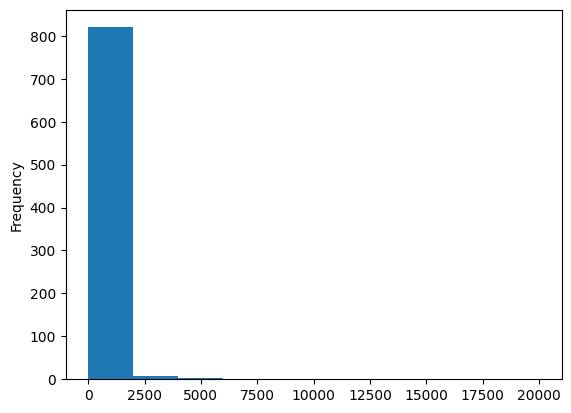

In [12]:
prices.plot(kind='hist')

# Model Evaluation

In [13]:
def train_and_test_model(X: np.ndarray,
                         y: np.ndarray,
                         model: Callable,
                         kfold_kwargs: Mapping[str, Any] = None,
                         clip_predicted_prices: bool = True,
                         plot: bool = True,
                         random_seed: int = 42):
    assert X.shape[0] == y.shape[0], \
        f"Feature array ({X.shape}) and target array {y.shape} must have the same number of rows."
    if kfold_kwargs is None:
        kfold_kwargs = {
            "n_splits": 5,
            "shuffle": True,
            "random_state": 42
        }
    kfold_kwargs["random_state"] = random_seed
    training_mean_relative_errors = []
    training_median_relative_errors = []
    testing_mean_relative_errors = []
    testing_median_relative_errors = []
    
    kf = KFold(**kfold_kwargs)
    print(kf)
    
    for train_index, test_index in tqdm(kf.split(X), leave=False, desc="KFold Cross-Validation", total=kf.get_n_splits()):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        training_predictions = model.predict(X_train)
        if clip_predicted_prices:
            training_predictions = np.clip(
                training_predictions,
                a_min = 0.0,
                a_max = None
            )
        training_relative_error = np.abs(training_predictions - y_train)/y_train
        training_mean_relative_errors.append(np.mean(training_relative_error))
        training_median_relative_errors.append(np.median(training_relative_error))
        
        testing_predictions = model.predict(X_test)
        if clip_predicted_prices:
            testing_predictions = np.clip(
                testing_predictions,
                a_min = 0.0,
                a_max = None
            )
        testing_relative_error = np.abs(testing_predictions - y_test)/y_test
        testing_mean_relative_errors.append(np.mean(testing_relative_error))
        testing_median_relative_errors.append(np.median(testing_relative_error))
        
        if plot:
            fig, ax = plt.subplots(
                figsize = (6,3),
                ncols = 2
            )
            sns.scatterplot(
                ax = ax[0],
                x = training_predictions,
                y = y_train,
            )
            sns.scatterplot(
                ax = ax[1],
                x = testing_predictions,
                y = y_test,
            )
            data_subsets = ("training data", "testing data")
            for ax_, subset in zip(ax, data_subsets):
                ax_.set_xlabel(f"predicted price\n({subset})")
                ax_.set_ylabel(f"real price\n({subset})")
            plt.tight_layout()
            plt.show()
        
    return {
        "training_mean_relative_errors": training_mean_relative_errors,
        "training_median_relative_errors": training_median_relative_errors,
        "testing_mean_relative_errors": testing_mean_relative_errors,
        "testing_median_relative_errors": testing_median_relative_errors,
    }, model

## On Sample Product Category

KFold(n_splits=5, random_state=42, shuffle=True)


KFold Cross-Validation:   0%|                                                                                                   | 0/5 [00:00<?, ?it/s]

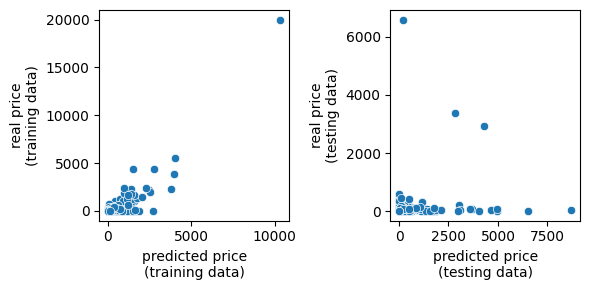

KFold Cross-Validation:  20%|██████████████████▏                                                                        | 1/5 [00:00<00:01,  2.05it/s]

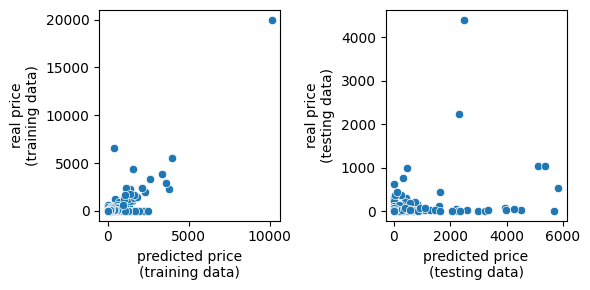

KFold Cross-Validation:  40%|████████████████████████████████████▍                                                      | 2/5 [00:01<00:01,  1.68it/s]

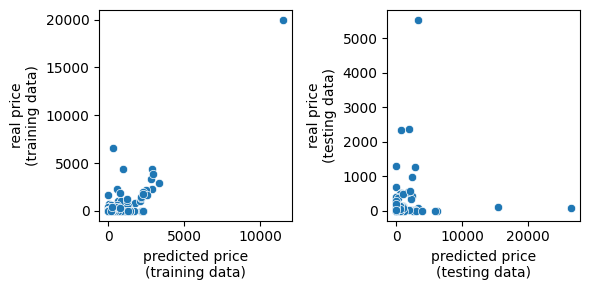

KFold Cross-Validation:  60%|██████████████████████████████████████████████████████▌                                    | 3/5 [00:02<00:01,  1.33it/s]

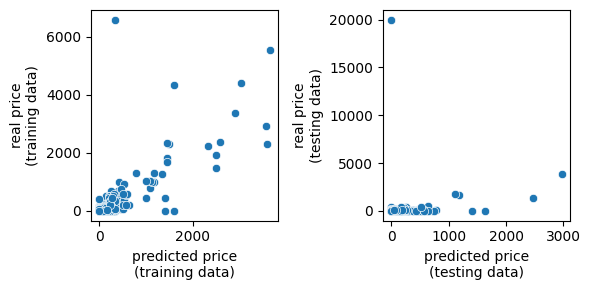

KFold Cross-Validation:  80%|████████████████████████████████████████████████████████████████████████▊                  | 4/5 [00:02<00:00,  1.43it/s]

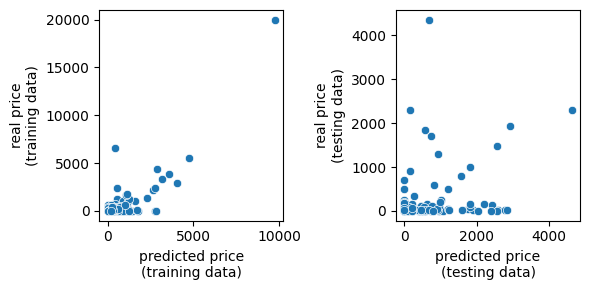

({'testing_mean_relative_errors': [30.538719358395365,
                                   37.070266568048574,
                                   28.478810609532427,
                                   27.236894205135748,
                                   32.88850625150505],
  'testing_median_relative_errors': [1.0, 1.032790011691752, 1.0, 1.0, 1.0],
  'training_mean_relative_errors': [16.388038781136526,
                                    17.555231599932483,
                                    16.387639143859126,
                                    5.568749338043237,
                                    13.457955676689716],
  'training_median_relative_errors': [1.0, 1.0, 1.0, 1.0, 1.0]},
 LinearRegression())


In [14]:
pprint(
    train_and_test_model(
        feature_array_for_this_category.values,
        prices.values,
        LinearRegression()
    )
)

KFold(n_splits=5, random_state=42, shuffle=True)


KFold Cross-Validation:   0%|                                                                                                   | 0/5 [00:00<?, ?it/s]

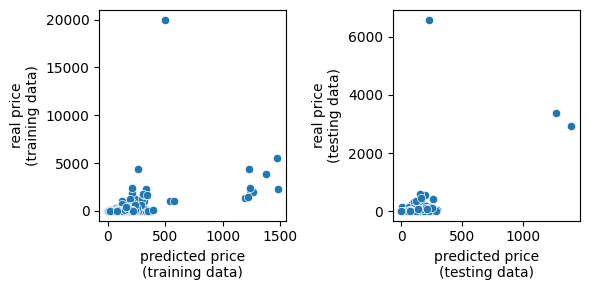

KFold Cross-Validation:  20%|██████████████████▏                                                                        | 1/5 [00:00<00:01,  3.23it/s]

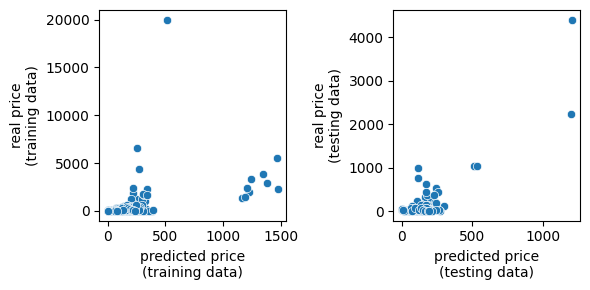

KFold Cross-Validation:  40%|████████████████████████████████████▍                                                      | 2/5 [00:00<00:01,  2.95it/s]

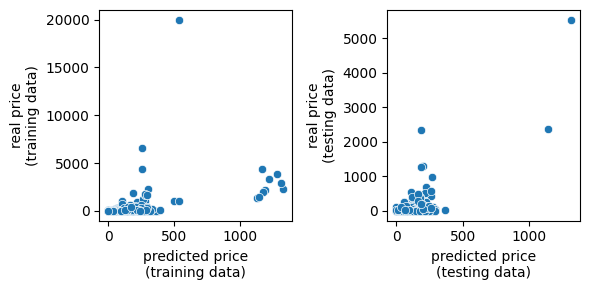

KFold Cross-Validation:  60%|██████████████████████████████████████████████████████▌                                    | 3/5 [00:01<00:00,  2.96it/s]

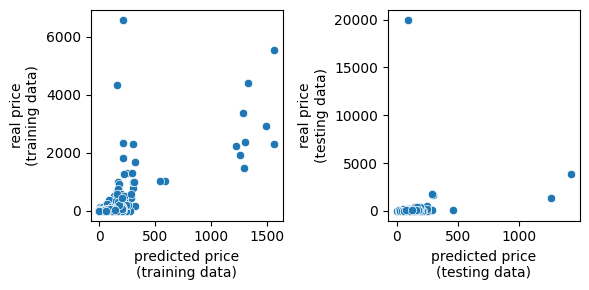

KFold Cross-Validation:  80%|████████████████████████████████████████████████████████████████████████▊                  | 4/5 [00:01<00:00,  2.64it/s]

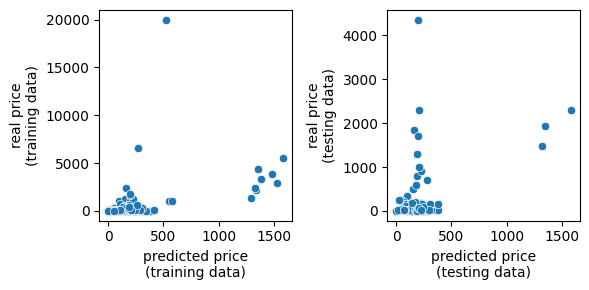

({'testing_mean_relative_errors': [6.926717661899291,
                                   7.606565974633386,
                                   10.016611715256236,
                                   10.530510315571805,
                                   11.519425578580464],
  'testing_median_relative_errors': [2.5800267053374175,
                                     3.1311016583314855,
                                     3.057603561311218,
                                     3.4174373380511156,
                                     3.1188472956409807],
  'training_mean_relative_errors': [10.237097076921792,
                                    10.454372412929295,
                                    9.561001407062763,
                                    7.227362759416019,
                                    8.979663933781342],
  'training_median_relative_errors': [3.1999961930865295,
                                      3.0584179682685653,
                                      2.8852873

In [15]:
pprint(
    train_and_test_model(
        feature_array_for_this_category.values,
        prices.values,
        ElasticNet(random_state = random_seed)
    )
)

KFold(n_splits=5, random_state=42, shuffle=True)


KFold Cross-Validation:   0%|                                                                                                   | 0/5 [00:00<?, ?it/s]

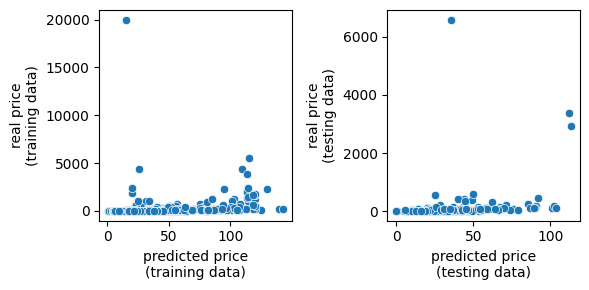

KFold Cross-Validation:  20%|██████████████████▏                                                                        | 1/5 [00:01<00:04,  1.05s/it]

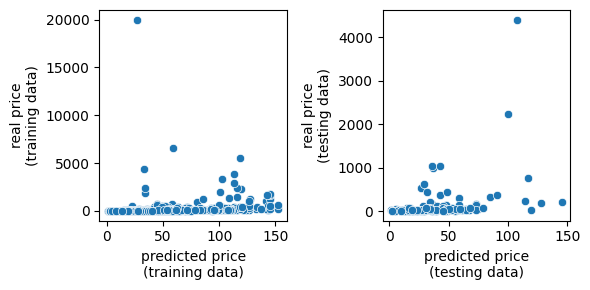

KFold Cross-Validation:  40%|████████████████████████████████████▍                                                      | 2/5 [00:01<00:02,  1.04it/s]

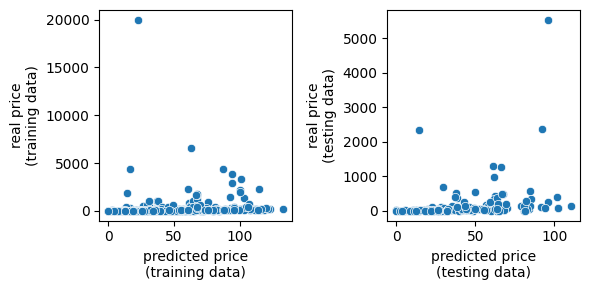

KFold Cross-Validation:  60%|██████████████████████████████████████████████████████▌                                    | 3/5 [00:02<00:01,  1.12it/s]

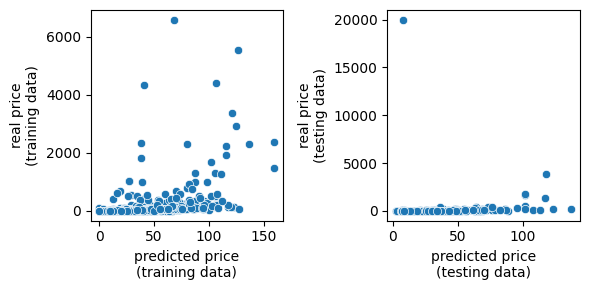

KFold Cross-Validation:  80%|████████████████████████████████████████████████████████████████████████▊                  | 4/5 [00:03<00:00,  1.20it/s]

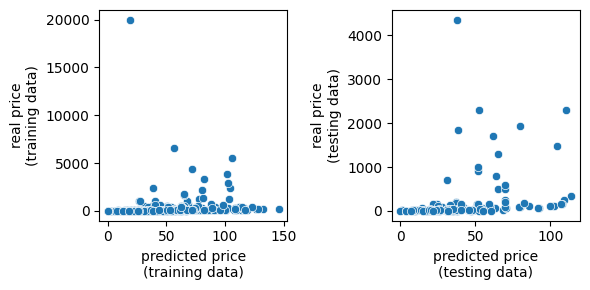

({'testing_mean_relative_errors': [0.8653035378499141,
                                   0.9892459903202983,
                                   1.6237912851336624,
                                   1.9766460867073843,
                                   1.6294672340830971],
  'testing_median_relative_errors': [0.5004597172852784,
                                     0.4885375664669013,
                                     0.6327946993873981,
                                     0.6780878466180233,
                                     0.512767856662013],
  'training_mean_relative_errors': [0.9339335627203051,
                                    1.035407526097952,
                                    0.7971070949545255,
                                    0.949095924141468,
                                    0.9098134933935488],
  'training_median_relative_errors': [0.35679185655381945,
                                      0.3338717072282478,
                                      0.339

In [16]:
pprint(
    train_and_test_model(
        feature_array_for_this_category.values,
        prices.values,
        xgb.XGBRegressor(**{
            "objective": 'reg:pseudohubererror',
            "n_estimators": 100,
            "eta": 0.3,
            "lambda": 1,
            "gamma": 0,
            "max_depth": None,
            "verbosity": 0,
            "random_state": random_seed,
        })
    )
)

KFold(n_splits=5, random_state=42, shuffle=True)


KFold Cross-Validation:   0%|                                                                                                   | 0/5 [00:00<?, ?it/s]

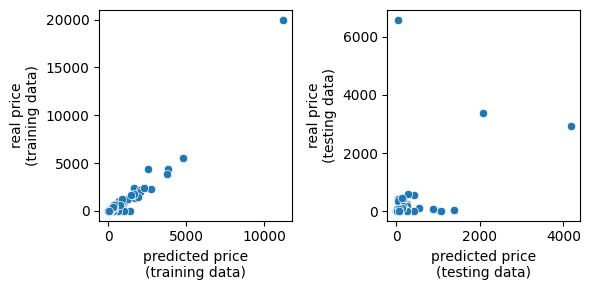

KFold Cross-Validation:  20%|██████████████████▏                                                                        | 1/5 [01:22<05:28, 82.05s/it]

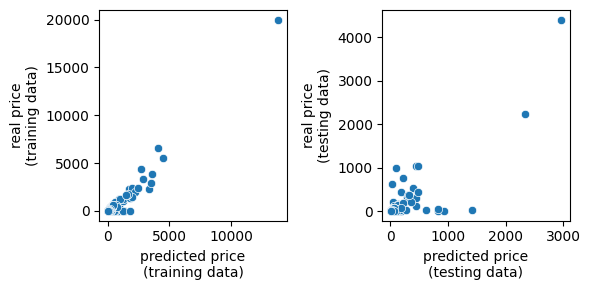

KFold Cross-Validation:  40%|████████████████████████████████████▍                                                      | 2/5 [02:42<04:02, 80.90s/it]

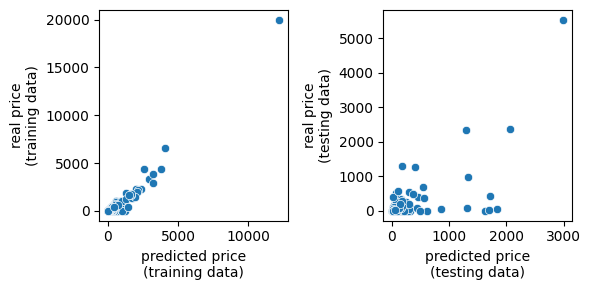

KFold Cross-Validation:  60%|██████████████████████████████████████████████████████▌                                    | 3/5 [04:02<02:41, 80.88s/it]

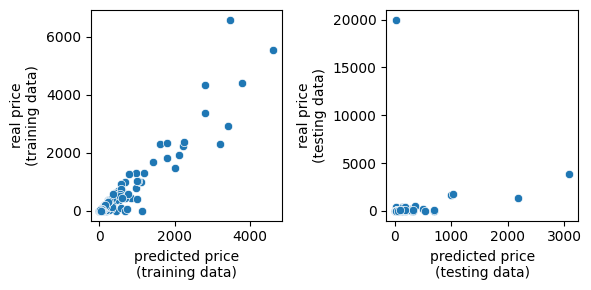

KFold Cross-Validation:  80%|████████████████████████████████████████████████████████████████████████▊                  | 4/5 [05:25<01:21, 81.44s/it]

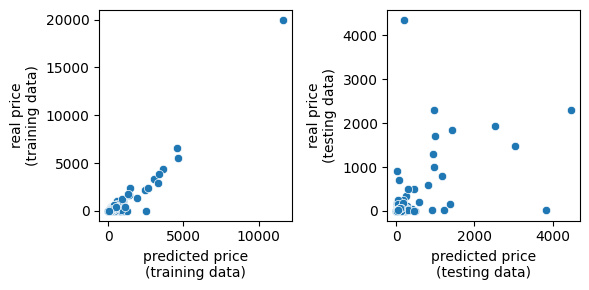

({'testing_mean_relative_errors': [5.89626542305458,
                                   5.672192276073581,
                                   6.4215572281693865,
                                   13.317586888615663,
                                   8.510839625785527],
  'testing_median_relative_errors': [0.6202633093525186,
                                     0.7240511946280781,
                                     0.752239999999999,
                                     0.7804571639171638,
                                     0.8076343906510821],
  'training_mean_relative_errors': [3.194371998239617,
                                    3.6685494213432466,
                                    3.078182172297115,
                                    2.6690965811506113,
                                    3.238184537877516],
  'training_median_relative_errors': [0.2977497643801005,
                                      0.2858658571428575,
                                      0.243122431

In [17]:
pprint(
    train_and_test_model(
        feature_array_for_this_category.values,
        prices.values,
        RandomForestRegressor(
            random_state = random_seed,
            criterion = "absolute_error"
        )
    )
)

## On All Product Categories

In [19]:
model = LinearRegression()

results_per_category: Mapping[str, Any] = dict()

for product_category in tqdm(all_product_category_assets.keys()):
    product_category_dataset = all_product_category_assets[product_category].processed_dataset
    product_category_dataset = product_category_dataset[product_category_dataset.price.astype(float) > 0.0]
    prices = product_category_dataset.price.astype(float)
    feature_array_for_this_category = product_category_dataset.drop(
        ['product_id','product_variant_id', 'price'], 
        axis="columns"
    )
    metrics, trained_model  = train_and_test_model(
        feature_array_for_this_category.values,
        prices.values,
        model,
        plot = False
    )
    results_per_category[product_category] = metrics
    

  0%|          | 0/20 [00:00<?, ?it/s]

KFold(n_splits=5, random_state=42, shuffle=True)



  5%|▌         | 1/20 [00:00<00:08,  2.23it/s]                       

KFold(n_splits=5, random_state=42, shuffle=True)



 10%|█         | 2/20 [01:13<13:01, 43.43s/it]                       

KFold(n_splits=5, random_state=42, shuffle=True)



 15%|█▌        | 3/20 [01:14<06:48, 24.01s/it]                       

KFold(n_splits=5, random_state=42, shuffle=True)



 20%|██        | 4/20 [01:15<03:53, 14.60s/it]                       

KFold(n_splits=5, random_state=42, shuffle=True)



 25%|██▌       | 5/20 [01:15<02:21,  9.46s/it]                       

KFold(n_splits=5, random_state=42, shuffle=True)



KFold Cross-Validation:   0%|          | 0/5 [00:00<?, ?it/s]
                                                             

KFold(n_splits=5, random_state=42, shuffle=True)



 35%|███▌      | 7/20 [01:16<01:03,  4.91s/it]                       

KFold(n_splits=5, random_state=42, shuffle=True)



 40%|████      | 8/20 [01:17<00:45,  3.82s/it]                       

KFold(n_splits=5, random_state=42, shuffle=True)



 45%|████▌     | 9/20 [01:18<00:35,  3.24s/it]                       

KFold(n_splits=5, random_state=42, shuffle=True)



 50%|█████     | 10/20 [01:19<00:26,  2.61s/it]                      

KFold(n_splits=5, random_state=42, shuffle=True)



 55%|█████▌    | 11/20 [01:21<00:21,  2.36s/it]                      

KFold(n_splits=5, random_state=42, shuffle=True)



 60%|██████    | 12/20 [01:31<00:35,  4.47s/it]                      

KFold(n_splits=5, random_state=42, shuffle=True)



 65%|██████▌   | 13/20 [01:31<00:22,  3.26s/it]                      

KFold(n_splits=5, random_state=42, shuffle=True)



 70%|███████   | 14/20 [01:34<00:18,  3.15s/it]                      

KFold(n_splits=5, random_state=42, shuffle=True)



 75%|███████▌  | 15/20 [01:34<00:11,  2.33s/it]                      

KFold(n_splits=5, random_state=42, shuffle=True)



KFold Cross-Validation:   0%|          | 0/5 [00:00<?, ?it/s]
                                                             

KFold(n_splits=5, random_state=42, shuffle=True)



KFold Cross-Validation:   0%|          | 0/5 [00:00<?, ?it/s]
                                                             

KFold(n_splits=5, random_state=42, shuffle=True)



 90%|█████████ | 18/20 [01:35<00:02,  1.11s/it]                      

KFold(n_splits=5, random_state=42, shuffle=True)



 95%|█████████▌| 19/20 [01:35<00:00,  1.06it/s]                      

KFold(n_splits=5, random_state=42, shuffle=True)



100%|██████████| 20/20 [01:42<00:00,  5.12s/it]                      


In [20]:
median_performance_on_testing_set_per_product_category = {
    category: np.median(results_per_category[category]['testing_median_relative_errors'])
    for category in results_per_category 
}
pprint(median_performance_on_testing_set_per_product_category)

{'animals & pet supplies': -0.20004558957800816,
 'apparel & accessories': 1.394318454922427,
 'arts & entertainment': -1.0,
 'baby & toddler': -1.3426028211595798e-10,
 'business & industrial': 0.5604771270692652,
 'cameras & optics': -0.14434323241527694,
 'electronics': 0.8671485499294749,
 'food, beverages & tobacco': 0.17875101722517528,
 'furniture': -0.03980243056972539,
 'hardware': 0.0018088517435934373,
 'health & beauty': 0.29653335088678345,
 'home & garden': 0.3041732269086888,
 'luggage & bags': 0.007460126675082771,
 'media': -1.0,
 'office supplies': -0.1990621451393755,
 'religious & ceremonial': 1.705423043347154,
 'software': 0.03243220970369521,
 'sporting goods': 0.3500071286455953,
 'toys & games': 0.007072810181453223,
 'vehicles & parts': -1.0}


In [21]:
model = xgb.XGBRegressor(**{
    "objective": 'reg:pseudohubererror',
    "n_estimators": 100,
    "eta": 0.3,
    "lambda": 1,
    "gamma": 0,
    "max_depth": None,
    "verbosity": 0,
    "random_state": random_seed,
})

results_per_category_xgb: Mapping[str, Mapping[str, List[float]]] = dict()
trained_model_per_category = dict()

smallest_to_largest = list(all_product_category_assets.keys())
smallest_to_largest.sort(key = lambda cat: all_product_category_assets[cat].processed_dataset.shape[0])
for cat in smallest_to_largest:
    print(cat.ljust(25), all_product_category_assets[cat].processed_dataset.shape[0])
print("\n")

for product_category in tqdm(smallest_to_largest):
    product_category_dataset = all_product_category_assets[product_category].processed_dataset
    product_category_dataset = product_category_dataset[product_category_dataset.price.astype(float) > 0.0]
    prices = product_category_dataset.price.astype(float)
    feature_array_for_this_category = product_category_dataset.drop(
        ['product_id','product_variant_id', 'price'], 
        axis="columns"
    )
    print(product_category, feature_array_for_this_category.shape[0])
    metrics, trained_model = train_and_test_model(
        feature_array_for_this_category.values,
        prices.values,
        model,
        plot = False
    )
    results_per_category_xgb[product_category] = metrics
    trained_model_per_category[product_category] = trained_model
    

religious & ceremonial    37
cameras & optics          155
baby & toddler            298
software                  402
office supplies           854
animals & pet supplies    858
luggage & bags            1374
business & industrial     3859
arts & entertainment      4480
toys & games              5654
food, beverages & tobacco 5803
electronics               6216
furniture                 6652
sporting goods            9738
health & beauty           11305
hardware                  13054
vehicles & parts          26081
home & garden             47980
media                     106747
apparel & accessories     331006




  0%|          | 0/20 [00:00<?, ?it/s]

religious & ceremonial 36
KFold(n_splits=5, random_state=42, shuffle=True)



  5%|▌         | 1/20 [00:00<00:13,  1.46it/s]                       

cameras & optics 152
KFold(n_splits=5, random_state=42, shuffle=True)



 10%|█         | 2/20 [00:01<00:11,  1.55it/s]                       

baby & toddler 291
KFold(n_splits=5, random_state=42, shuffle=True)



 15%|█▌        | 3/20 [00:02<00:16,  1.05it/s]                       

software 312
KFold(n_splits=5, random_state=42, shuffle=True)



 20%|██        | 4/20 [00:04<00:21,  1.32s/it]                       

office supplies 803
KFold(n_splits=5, random_state=42, shuffle=True)



 25%|██▌       | 5/20 [00:11<00:49,  3.29s/it]                       

animals & pet supplies 832
KFold(n_splits=5, random_state=42, shuffle=True)



 30%|███       | 6/20 [00:18<01:05,  4.71s/it]                       

luggage & bags 1368
KFold(n_splits=5, random_state=42, shuffle=True)



 35%|███▌      | 7/20 [00:27<01:17,  5.96s/it]                       

business & industrial 3657
KFold(n_splits=5, random_state=42, shuffle=True)



 40%|████      | 8/20 [00:41<01:43,  8.60s/it]                       

arts & entertainment 4327
KFold(n_splits=5, random_state=42, shuffle=True)



 45%|████▌     | 9/20 [01:09<02:42, 14.80s/it]                       

toys & games 5547
KFold(n_splits=5, random_state=42, shuffle=True)



 50%|█████     | 10/20 [01:22<02:21, 14.17s/it]                      

food, beverages & tobacco 5665
KFold(n_splits=5, random_state=42, shuffle=True)



 55%|█████▌    | 11/20 [01:56<03:01, 20.16s/it]                      

electronics 5997
KFold(n_splits=5, random_state=42, shuffle=True)



 60%|██████    | 12/20 [02:34<03:25, 25.74s/it]                      

furniture 6601
KFold(n_splits=5, random_state=42, shuffle=True)



 65%|██████▌   | 13/20 [03:16<03:34, 30.63s/it]                      

sporting goods 8600
KFold(n_splits=5, random_state=42, shuffle=True)



 70%|███████   | 14/20 [03:37<02:46, 27.70s/it]                      

health & beauty 10849
KFold(n_splits=5, random_state=42, shuffle=True)



 75%|███████▌  | 15/20 [04:43<03:15, 39.13s/it]                      

hardware 13007
KFold(n_splits=5, random_state=42, shuffle=True)



 80%|████████  | 16/20 [05:13<02:25, 36.31s/it]                      

vehicles & parts 24490
KFold(n_splits=5, random_state=42, shuffle=True)



 85%|████████▌ | 17/20 [08:36<04:20, 86.67s/it]                      

home & garden 47243
KFold(n_splits=5, random_state=42, shuffle=True)



 90%|█████████ | 18/20 [14:38<05:38, 169.19s/it]                     

media 78147
KFold(n_splits=5, random_state=42, shuffle=True)



 95%|█████████▌| 19/20 [16:38<02:34, 154.43s/it]                     

apparel & accessories 327136
KFold(n_splits=5, random_state=42, shuffle=True)



100%|██████████| 20/20 [50:00<00:00, 150.00s/it]                      


In [22]:
xgboost_median_performance_on_testing_set_per_product_category = {
    category: np.median(results_per_category_xgb[category]['testing_median_relative_errors'])
    for category in results_per_category_xgb 
}
pprint(xgboost_median_performance_on_testing_set_per_product_category)

{'animals & pet supplies': 0.0033338720148259945,
 'apparel & accessories': -0.05336018343331032,
 'arts & entertainment': -0.010557325641114503,
 'baby & toddler': -0.9862987987987988,
 'business & industrial': -0.00697947575392578,
 'cameras & optics': -0.9978935809572276,
 'electronics': 0.0015063217103108498,
 'food, beverages & tobacco': 0.015032307682387771,
 'furniture': -0.012911488926297225,
 'hardware': 0.0004662503017468399,
 'health & beauty': -0.0021105354277706025,
 'home & garden': -0.002646993603226701,
 'luggage & bags': -0.0011215845743815104,
 'media': 0.010040089277073585,
 'office supplies': -0.014771591052125277,
 'religious & ceremonial': -0.04447692843108803,
 'software': 0.000240478515625,
 'sporting goods': 9.45945731480654e-05,
 'toys & games': 0.00011747974460407839,
 'vehicles & parts': -0.002798421934702511}


In [23]:
pprint(trained_model_per_category)

{'animals & pet supplies': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', lambda=1, learning_rate=0.300000012,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, ...),
 'apparel & accessories': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, feature_types

In [26]:
with open(f"./app/{datetime.now().strftime('%Y%m%d%H%M%S')}_all_product_category_to_model.pkl", "wb") as handle:
      dill.dump(
          trained_model_per_category,
          handle,
          protocol = dill.HIGHEST_PROTOCOL
      )

In [29]:
with open(f"./app/20221202164110_all_product_category_to_model.pkl", "rb") as handle:
      test_copy = dill.load(handle)